In [1]:
import numpy as np
import pandas as pd
import KetSugar as ks #my own syntatic sugar for numpy-based quantum mechanics
import MaxLik as ml #my own maxlik reconstruction library
import matplotlib.pyplot as plt
from scipy.optimize import minimize
DEG = np.pi/180.
btf = lambda x: ks.ketbra(x,x)

def load_data(fnIN, CH):
    if ".json" in fnIN:
        DAT = pd.read_json(fnIN, typ="series", orient="records")
        DAT["Data"] = np.array(DAT["Data"])
        Data = DAT["Data"][:, CH]
        return Data
    else:
        raise Exception('Type not supported')


#Prepare projection definition for Maxlik
#we reconstruct two-qubit states
Q1 = [ks.LO, ks.HI, ks.HLO, ks.HHI, ks.CLO, ks.CHI]
Q2 = [ks.LO, ks.HI, ks.HLO, ks.HHI, ks.CLO, ks.CHI]
ORDER = [Q1, Q2]
RPV = ml.MakeRPV(ORDER, False)



#Load data 
fn = "CaseEv4test.json"
datref = load_data(fn, 14)
#reshape into individual tomograms
#we have nx36 measurements in n tomograms
length = datref.size
tomogramsref = datref.reshape((length//36, 36))
reconstructionsref = [ml.Reconstruct(tomogram, RPV, 1000, 1e-9) \
    for tomogram in tomogramsref]
reconstructionsref = np.array(reconstructionsref)

fn2 = "CaseErefv3.json"
datref2 = load_data(fn2, 14)
#reshape into individual tomograms
#we have nx36 measurements in n tomograms
length = datref2.size
tomogramsref2 = datref2.reshape((length//36, 36))
reconstructionsref2 = [ml.Reconstruct(tomogram, RPV, 1000, 1e-9) \
    for tomogram in tomogramsref2]
reconstructionsref2 = np.array(reconstructionsref2)

MaxLik: Numba Allowed: True => use cycle-based K-vector construction


In [11]:

def theo_ket(x, y):
    cx = np.cos(x)
    sx = np.sin(x)
    cy = np.cos(y)
    sy = np.sin(y)
    z = y/2 - np.pi/4

    ket1 = np.array([cx,sx]).reshape((2,1)).astype(complex)
    ket2 = np.array([cy,sy]).reshape((2,1)).astype(complex)
    return np.kron(ket1, ket2)

    vec = np.array([[
        0,
        -np.cos(x),
        -np.cos(x),
        -np.sqrt(1 - (1/np.tan(x))**2) * np.sin(x)
    ]]).T
    return vec/(ks.braket(vec, vec).real**0.5)


xs2 = np.array(sorted(list(np.arange(45,55,0.5)*DEG) + list(np.arange(55,90,2)*DEG)))
xs2[0] = xs2[0]+1e-4
#test version - shorter
xs = np.arange(55,90,2)*DEG

ys = 0.5*np.arcsin(1/np.tan(xs))
ys2 = 0.5*np.arcsin(1/np.tan(xs2))


In [12]:
def theo_ket2(x, y):
    cx = np.cos(x)
    sx = np.sin(x)
    cy = np.cos(y)
    sy = -np.sin(y)
    z = y/2 - np.pi/4

    ket1 = np.array([cx,sx]).reshape((2,1)).astype(complex)
    ket2 = np.array([cy,sy]).reshape((2,1)).astype(complex)
    return np.kron(ket1, ket2)

thrhos1 = np.array([btf(theo_ket2(x, y)) for x, y in zip(xs, ys)])
thrhos2 = np.array([btf(theo_ket2(x, y)) for x, y in zip(xs2, ys2)])

In [13]:
def shift_phase(rho_test, rho_ref):
    def cost(x):
        f1 = np.exp(x[0]*1j)
        f2 = np.exp(x[0]*1j)
        u = np.diag([1, f2, f1, f1*f2])
        r1 = ks.ApplyOp(rho_test, u)
        return -ks.Overlap(r1, rho_ref).real
    
    R = minimize(cost, x0=(1*DEG, 5*DEG))
    f1 = np.exp(R['x'][0]*1j)
    f2 = np.exp(R['x'][0]*1j)    
    u = np.diag([1, f2, f1, f1*f2])
    return R['fun'], R['x'], ks.ApplyOp(rho_test, u)

i = 0




C:\Users\QOLO\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


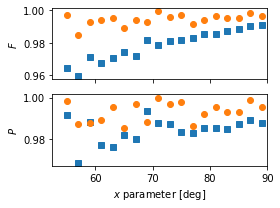

In [20]:
fids_cal = np.array([ks.Overlap(rth, rexp) for rth, rexp in zip(thrhos1, reconstructionsref)])
fids_noncal = np.array([ks.Overlap(rth, rexp) for rth, rexp in zip(thrhos2, reconstructionsref2)])

purs_cal = np.array([ks.Purity(rexp) for rexp in reconstructionsref])
purs_noncal = np.array([ks.Purity(rexp) for rexp in reconstructionsref2])

#the references were measured more densely near 50, while calibration test was done from 55 above.
#let us plot only those points with a direct calibrated counter-part of avoid confusion
sel = (xs2/DEG) >= 55

fig, axs = plt.subplots(2, 1, figsize=(4, 3), sharex=True)

axs[0].plot(xs2[sel]/DEG, fids_noncal[sel], "s", label='Non-calibrated')
axs[0].plot(xs/DEG, fids_cal, "o", label='Calibrated')
axs[0].set_xlim(50, 90)
axs[0].set_ylabel('$F$')
# axs[0].legend()

axs[1].plot(xs2[sel]/DEG, purs_noncal[sel], "s", label='Non-calibrated')
axs[1].plot(xs/DEG, purs_cal, "o", label='Calibrated')
axs[1].set_xlim(52.5, 90)
axs[1].set_xlabel('$x$ parameter [deg]')
axs[1].set_ylabel('$P$')

plt.tight_layout()
plt.show()